# Results request - CAZ_R performance on TESSy

In [340]:
import torch
import yaml
import wandb
import argparse
import numpy as np
import pandas as pd
import os
import sys

from copy import deepcopy
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

BASE_DIR = Path(os.path.abspath(''))
sys.path.append(str(BASE_DIR))
os.chdir(BASE_DIR)

# user-defined modules
from multimodal.models import BERT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

config = yaml.safe_load(open("config_MM.yaml"))
data_config = config['data']
defined_antibiotics = sorted(list(set(data_config['antibiotics']['abbr_to_names'].keys()) - set(data_config['exclude_antibiotics'])))
num_ab = len(defined_antibiotics)
ab_to_idx = {ab: idx for idx, ab in enumerate(defined_antibiotics)}
specials = config['specials']
max_seq_len = 56

## Load and prepare datasets

In [383]:
ds_path = data_config['TESSy']['load_path']
ds_TESSy = pd.read_pickle(ds_path)
ds_NCBI = pd.read_pickle(data_config['NCBI']['load_path'])
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 1].reset_index(drop=True)
print(f"Total number of samples in TESSy: {len(ds_TESSy):,}")

antibiotics = ['CAZ', 'CIP', 'AMP', 'GEN']
ds_CAZ = ds_TESSy.copy()
ds_CAZ = ds_CAZ[ds_CAZ['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
ds_CAZ['phenotypes'] = ds_CAZ['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
ds_CAZ.drop(columns=['num_R', 'num_S', 'num_ab'], inplace=True)
ds_CAZ = ds_CAZ.sample(frac=1, random_state=config['random_state']).reset_index(drop=True)
print(f"Number of selected samples in ds_CAZ: {len(ds_CAZ):,}")

Total number of samples in TESSy: 1,440,857
Number of selected samples in ds_CAZ: 703,739


In [384]:
vocab_path = BASE_DIR / config['fine_tuning']['loadpath_vocab']
vocab = torch.load(vocab_path)

class MMInferenceDataset(Dataset):
    
    def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials, selected_ab_idx, patient_info_only=False):
        self.ds = ds.reset_index(drop=True)
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.specials = specials
        self.CLS, self.PAD = specials['CLS'], specials['PAD']
        self.GENE_MASK, self.AB_MASK = specials['GENE_MASK'], specials['AB_MASK']
        self.device = device
        self.ab = defined_antibiotics[selected_ab_idx]
        
        self.phenotypes = self.ds['phenotypes'].tolist()
        self.year_col = self.ds['year'].astype(str).tolist()
        self.country_col = self.ds['country'].tolist()
        self.gender_col = self.ds['gender'].tolist()
        self.age_col = self.ds['age'].astype(int).astype(str).tolist()
        
        self.columns = ['indices_masked', 'token_types', 'attn_mask', 'target_res', 'masked_sequences']
        
    def prepare_dataset(self):
        masked_phenotypes = []
        target_res = []
        for phen_list in self.phenotypes:
            masked_phen_list = []
            for p in phen_list:
                if p.split('_')[0] != self.ab:
                    if patient_info_only:
                        pass
                    else:
                        masked_phen_list.append(p)
                else:
                    if p == self.ab+'_R':
                        target_res.append(1)
                    else:
                        target_res.append(0)
                    masked_phen_list.append(self.AB_MASK)
            masked_phenotypes.append(masked_phen_list)

        masked_sequences = [[specials['CLS'], self.year_col[i], self.country_col[i], self.gender_col[i], self.age_col[i]] + masked_phenotypes[i] for i in range(len(self.ds))]
        token_types = [[0]*5 + [2]*(len(masked_sequences[i])-5) for i in range(len(self.ds))]
        ########### without patient info ###########
        # masked_sequences = [[specials['CLS']] + masked_phenotypes[i] for i in range(len(self.ds))]
        # token_types = [[0] + [2]*(len(masked_sequences[i])-1) for i in range(len(self.ds))]
        
        masked_sequences = [seq + [specials['PAD']]*(max_seq_len-len(seq)) for seq in masked_sequences]
        indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        token_types = [tt + [2]*(max_seq_len-len(tt)) for tt in token_types]
        attn_mask = [[False if token == specials['PAD'] else True for token in seq] for seq in masked_sequences]
        
        rows = zip(indices_masked, token_types, attn_mask, target_res, masked_sequences)
        self.df = pd.DataFrame(rows, columns=self.columns)
    
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        
        input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
        token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
        masked_sequences = item['masked_sequences']
        target_res = torch.tensor(item['target_res'], dtype=torch.float, device=self.device)
        attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
        return input, token_types, attn_mask, target_res, masked_sequences

CAZ_idx = ab_to_idx['CAZ']
CIP_idx = ab_to_idx['CIP']
AMP_idx = ab_to_idx['AMP']
GEN_idx = ab_to_idx['GEN']

ds_exp = ds_CAZ.copy()
num_samples = 40000
ab_idx = CAZ_idx
patient_info_only = True

selected_ab = defined_antibiotics[ab_idx]
print("selected ab:", selected_ab)

ds_inference = MMInferenceDataset(
    ds_exp.iloc[:num_samples],
    vocab,
    defined_antibiotics,
    max_seq_len,
    specials,
    ab_idx,
    patient_info_only=patient_info_only
)
inference_loader = DataLoader(ds_inference, batch_size=512, shuffle=False)

selected ab: CAZ


In [385]:
# ds_NCBI_CAZ = ds_MM.copy()
# ds_NCBI_CAZ.fillna(pad_token, inplace=True)
# ds_NCBI_CAZ['phenotypes'] = ds_NCBI_CAZ['phenotypes'].apply(lambda x: [p for p in x if p.split('_')[0] in antibiotics])
# # ds_NCBI_CAZ = ds_NCBI_CAZ[ds_NCBI_CAZ['phenotypes'].apply(lambda x: 'CAZ_R' in x)].reset_index(drop=True)
# ds_NCBI_CAZ = ds_NCBI_CAZ[ds_NCBI_CAZ['phenotypes'].apply(lambda x: all([ab in [p.split('_')[0] for p in x] for ab in antibiotics]))].reset_index(drop=True)
# ds_NCBI_CAZ.head()
# print(f"Number of selected samples: {len(ds_NCBI_CAZ):,}")

In [386]:
# vocab = torch.load(BASE_DIR / config['fine_tuning']['loadpath_vocab'])

# class MMInferenceDataset_NCBI(Dataset):
    
#     def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials, selected_ab_idx):
#         self.ds = ds
#         self.vocab = vocab
#         self.max_seq_len = max_seq_len
#         self.specials = specials
#         self.CLS, self.PAD, self.MASK = specials['CLS'], specials['PAD'], specials['MASK']
#         self.device = device
#         self.ab = defined_antibiotics[selected_ab_idx]
        
#         self.phenotypes = self.ds['phenotypes'].tolist()
#         self.year_col = self.ds['year'].astype(str).tolist()
#         self.country_col = self.ds['country'].tolist()
        
#         self.columns = ['indices_masked', 'token_types', 'attn_mask', 'target_res', 'masked_sequences']
        
#     def prepare_dataset(self):
#         masked_phenotypes = []
#         target_caz_res = []
#         for phen_list in self.phenotypes:
#             masked_phen_list = []
#             for p in phen_list:
#                 if p.split('_')[0] != self.ab:
#                     masked_phen_list.append(p)
#                     # pass
#                 else:
#                     if p == self.ab+'_R':
#                         target_caz_res.append(1)
#                     else:
#                         target_caz_res.append(0)
#                     masked_phen_list.append(specials['MASK'])
#             masked_phenotypes.append(masked_phen_list)

#         masked_sequences = [[specials['CLS'], self.year_col[i], self.country_col[i]] + masked_phenotypes[i] for i in range(len(self.ds))]
#         token_types = [[0]*5 + [2]*(len(masked_sequences[i])-5) for i in range(len(self.ds))]
#         masked_sequences = [seq + [pad_token]*(max_seq_len-len(seq)) for seq in masked_sequences]
#         indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
#         token_types = [tt + [2]*(max_seq_len-len(tt)) for tt in token_types]
#         attn_mask = [[False if token == pad_token else True for token in seq] for seq in masked_sequences]
        
#         rows = zip(indices_masked, token_types, attn_mask, target_caz_res, masked_sequences)
#         self.df = pd.DataFrame(rows, columns=self.columns)
    
#     def __len__(self):
#         return len(self.ds)
    
#     def __getitem__(self, idx):
#         item = self.df.iloc[idx]
        
#         input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
#         token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
#         masked_sequences = item['masked_sequences']
#         target_res = torch.tensor(item['target_res'], dtype=torch.float, device=self.device)
#         attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
#         return input, token_types, attn_mask, target_res

# CAZ_idx = ab_to_idx['CAZ']
# CIP_idx = ab_to_idx['CIP']
# AMP_idx = ab_to_idx['AMP']
# GEN_idx = ab_to_idx['GEN']
# CTX_idx = ab_to_idx['CTX']
# ab_idx = CAZ_idx
# selected_ab = defined_antibiotics[ab_idx]
# print("ab idx (ab):", ab_idx, selected_ab)

# num_samples_NCBI = len(ds_NCBI_CAZ)
# ds_inference_NCBI = MMInferenceDataset_NCBI(ds_NCBI_CAZ, vocab, defined_antibiotics, max_seq_len, specials, ab_idx)
# inference_loader_NCBI = DataLoader(ds_inference_NCBI, batch_size=512, shuffle=False)

## Loss function experimentation

**Setup:** Train the model on a dataset mixed with (CAZ) susceptible and resistant isolates.  
Then compare model behaviour when fed resistant or ssuceptible isolates, both when other phenotypes are present or when it's only patient data

**Q1:** Given the data imbalance, how does the model behave when doing inference on susceptible or resistant isolates?  
How does this differ when more information is presented

**Q2:** How does this change when weighted loss is introduced in training?

**Q3:** How does this change when focal loss is introduced in training?

### Training

In [412]:
class TrainDataset(Dataset):
    
    def __init__(self, ds, vocab, defined_antibiotics, max_seq_len, specials):
        self.ds = ds.reset_index(drop=True)
        self.vocab = vocab
        self.max_seq_len = max_seq_len
        self.specials = specials
        self.CLS, self.PAD, self.AB_MASK = specials['CLS'], specials['PAD'], specials['AB_MASK']
        self.device = device
        
        self.num_ab = len(defined_antibiotics)
        self.ab_to_idx = {ab: idx for idx, ab in enumerate(defined_antibiotics)}
        self.enc_res = {'S': 0, 'R': 1}
        
        self.year_col = self.ds['year'].astype(str).tolist()
        self.country_col = self.ds['country'].tolist()
        self.gender_col = self.ds['gender'].tolist()
        self.age_col = self.ds['age'].astype(int).astype(str).tolist()
        
        self.columns = ['indices_masked', 'token_types', 'target_res', 'masked_sequences']
        
    def prepare_dataset(self, mask_prob:float=0.5):
        pheno_sequences = deepcopy(self.ds['phenotypes'].tolist())
        masked_phenotypes = []
        target_resistances = []
        for seq in pheno_sequences:
            seq_len = len(seq)
            target_res = np.array([-1]*self.num_ab)
            token_mask = np.random.rand(seq_len) < mask_prob
            if not token_mask.any():
                token_mask[np.random.randint(0, seq_len)] = True
            for idx in token_mask.nonzero()[0]:
                ab, res = seq[idx].split('_')
                target_res[self.ab_to_idx[ab]] = self.enc_res[res]
                seq[idx] = self.AB_MASK
            masked_phenotypes.append(seq)
            target_resistances.append(target_res)
        
        seq_starts = [[specials['CLS'], self.year_col[i], self.country_col[i], self.gender_col[i], self.age_col[i]] for i in range(len(self.ds))]
        masked_sequences = [seq_start + masked_phenotypes[i] for i, seq_start in enumerate(seq_starts)]
        token_types = [[0]*len(seq_starts[0]) + [2]*(len(masked_phenotypes[i])) for i in range(len(self.ds))]
        ## extend to max_seq_len
        masked_sequences = [seq + [specials['PAD']]*(self.max_seq_len-len(seq)) for seq in masked_sequences]
        token_types = [tt + [2]*(self.max_seq_len-len(tt)) for tt in token_types]
        
        indices_masked = [vocab.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        
        rows = zip(indices_masked, token_types, target_resistances, masked_sequences)
        self.df = pd.DataFrame (rows, columns=self.columns)
    
    
    def __len__(self):
        return len(self.ds)
    
    
    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        
        input = torch.tensor(item['indices_masked'], dtype=torch.long, device=self.device)
        token_types = torch.tensor(item['token_types'], dtype=torch.long, device=self.device)
        masked_sequences = item['masked_sequences']
        target_res = torch.tensor(item['target_res'], dtype=torch.float32, device=self.device)
        attn_mask = (input != self.vocab[self.PAD]).unsqueeze(0).unsqueeze(1)
        
        return input, token_types, attn_mask, target_res, masked_sequences

ds_exp = ds_CAZ.iloc[:50000]    
val_share = 0.2  
train_indices, val_indices = np.split(np.arange(len(ds_exp)), [int((1-val_share)*len(ds_exp))])
ds_train = TrainDataset(ds_exp.iloc[train_indices], vocab, defined_antibiotics, max_seq_len, specials)
train_loader = DataLoader(ds_train, batch_size=32, shuffle=False)

In [413]:
## Loss function and optimizer
from torch.optim import AdamW
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.nn import functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=4, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
        
    def forward(self, input, target):
        BCE_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
        pt = torch.exp(-BCE_loss)
        loss = BCE_loss * (1-pt)**self.gamma
        
        if self.alpha >= 0:
            alpha_t = self.alpha * target + (1-self.alpha) * (1-target)
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

ab_criterions = [BCEWithLogitsLoss(reduction='none').to(device) for _ in range(num_ab)]
ab_criterions_focal = [FocalLoss(alpha=0.5, gamma=1, reduction='none').to(device) for _ in range(num_ab)]

In [414]:
vocab_size = len(vocab)

bert = BERT(
    config,
    vocab_size=vocab_size,
    max_seq_len=max_seq_len,
    num_ab=num_ab,
    pad_idx=vocab[specials['PAD']],
    pheno_only=True
).to(device)
CTX_before = bert.classification_layer[ab_to_idx['CTX']].state_dict()['classifier.3.bias'].clone()
CAZ_before = bert.classification_layer[ab_to_idx['CAZ']].state_dict()['classifier.3.bias'].clone()
print("CTX before training:", CTX_before)
print("CAZ before training:", CAZ_before)

optimizer = AdamW(bert.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs = 10
ds_train.prepare_dataset(mask_prob=0.5)

first_batch_losses = []
epoch_losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}")
    for i, batch in enumerate(train_loader):
        if i == 0:
            print(f"Batch {i+1}") 
        optimizer.zero_grad()
        input, token_types, attn_mask, target_res, masked_sequences = batch
        
        pred_logits = bert(input, token_types, attn_mask)
        ab_mask = target_res != -1
        ab_indices = ab_mask.any(dim=0).nonzero().squeeze(-1).tolist()
        losses = []
        epoch_loss = 0
        for ab_idx in ab_indices:
            mask = ab_mask[:, ab_idx]
            # criterion = ab_criterions[ab_idx]
            criterion = ab_criterions_focal[ab_idx]
            ab_targets = target_res[mask, ab_idx]
            ab_loss = criterion(pred_logits[mask, ab_idx], ab_targets)
            mean_loss = torch.mean(ab_loss)
            losses.append(mean_loss)
            if i == 0:
                print("Antibiotic:", defined_antibiotics[ab_idx])
                print("pred_sigmoid:", torch.sigmoid(pred_logits[mask, ab_idx]).detach())
                print("ab targets:", ab_targets)
                print("correct:", torch.eq(torch.sigmoid(pred_logits[mask, ab_idx]) > 0.5, ab_targets.bool()))
                print("ab_loss:", ab_loss.detach())
                print("mean ab_loss:", mean_loss)
                print()
        loss = sum(losses) / len(losses)
        epoch_loss += loss.item()
        if i == 0:
            print("Total mean loss of first batch:", loss.item())
            first_batch_losses.append(loss.item())
        loss.backward()
        optimizer.step() 
        if i == 0:
            CTX_after = bert.classification_layer[ab_to_idx['CTX']].state_dict()['classifier.3.bias'].clone()
            CAZ_after = bert.classification_layer[ab_to_idx['CAZ']].state_dict()['classifier.3.bias'].clone()
            print("CTX after update:", CTX_after)
            print("CAZ after update:", CAZ_after)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1} loss: {epoch_loss:.4f}")   
    print("="*80)
print("Training finished")

CTX before training: tensor([0.], device='cuda:0')
CAZ before training: tensor([0.], device='cuda:0')
Epoch 1
Batch 1
Antibiotic: AMP
pred_sigmoid: tensor([0.3723, 0.3557, 0.2651, 0.3459, 0.4354, 0.4739, 0.5983, 0.3498, 0.6059,
        0.4214, 0.6012, 0.6360, 0.4399, 0.3971, 0.5107], device='cuda:0')
ab targets: tensor([0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 1.],
       device='cuda:0')
correct: tensor([ True, False,  True, False,  True,  True, False,  True,  True, False,
        False, False, False, False,  True], device='cuda:0')
ab_loss: tensor([0.0867, 0.3329, 0.0408, 0.3472, 0.1245, 0.1522, 0.2729, 0.0753, 0.0988,
        0.2500, 0.2763, 0.3214, 0.2300, 0.2784, 0.1644], device='cuda:0')
mean ab_loss: tensor(0.2035, device='cuda:0', grad_fn=<MeanBackward0>)

Antibiotic: CAZ
pred_sigmoid: tensor([0.6517, 0.5524, 0.7670, 0.5084, 0.8571, 0.5289, 0.3392, 0.4706, 0.3177,
        0.5478, 0.5712, 0.6409, 0.3323, 0.3956, 0.8083, 0.5856, 0.4783, 0.5124],
       device='cuda

In [415]:
CTX_after = bert.classification_layer[ab_to_idx['CTX']].state_dict()['classifier.3.bias'].clone()
CAZ_after = bert.classification_layer[ab_to_idx['CAZ']].state_dict()['classifier.3.bias'].clone()
print("CTX after training:", CTX_after)
print("CAZ after training:", CAZ_after)

CTX after training: tensor([0.], device='cuda:0')
CAZ after training: tensor([-4.9672e-05], device='cuda:0')


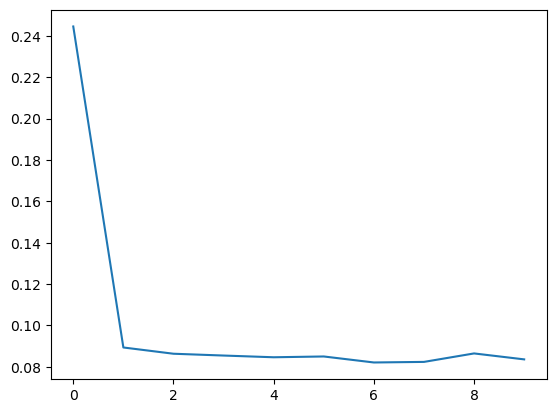

In [416]:
plt.plot(first_batch_losses)    

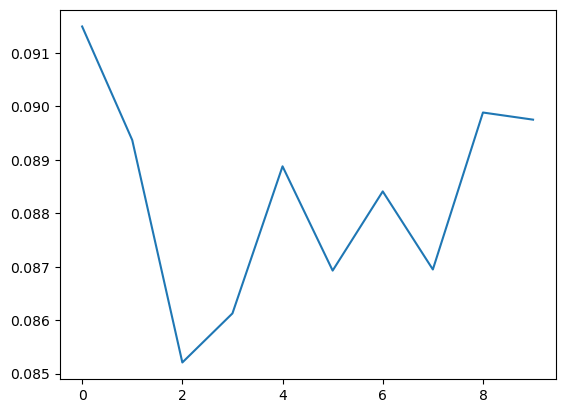

In [417]:
plt.plot(epoch_losses)

## Focal loss vs. CrossEntropyLoss

Regualar BCELoss

In [527]:
x = torch.tensor(np.arange(0.0001, 1, 0.0001), dtype=torch.float32)
print(x.shape, min(x), max(x))
y_pos = torch.tensor([1]*len(x), dtype=torch.float32)
y_neg = torch.tensor([0]*len(x), dtype=torch.float32)

BCELoss = torch.nn.BCELoss(reduction='none')
loss_neg = BCELoss(x, y_neg)
loss_pos = BCELoss(x, y_pos)

torch.Size([9999]) tensor(1.0000e-04) tensor(0.9999)


Class-weighted BCELoss

In [528]:
# alpha_weights = [0.6, 0.8]
alpha_weights = [0.25, 0.5, 0.75]
losses_positive = []
losses_negative = []
for alpha in alpha_weights:
    losses_positive.append(alpha*BCELoss(x, y_pos))
    losses_negative.append((1-alpha)*BCELoss(x, y_neg))

In [529]:
from datetime import datetime
import time
datetime.now().strftime("%H:%M:%S")
time_elapsed = time.gmtime(24*60*60-1)
num_days = (24*60*60+1) // (60*60*24)
print(f"Elapsed time: {num_days:02d}-{time.strftime('%H:%M:%S', time_elapsed)}")

Elapsed time: 01-23:59:59


Focal Loss

In [530]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=4, reduction='none'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
        
    def forward(self, input, target):
        BCE_loss = F.binary_cross_entropy_with_logits(input, target, reduction='none')
        pt = torch.exp(-BCE_loss)
        loss = BCE_loss * (1-pt)**self.gamma
        
        if self.alpha >= 0:
            alpha_t = self.alpha * target + (1-self.alpha) * (1-target)
            loss = alpha_t * loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

alpha_vals = [0.25, 0.5, 0.75]
gamma = 2
x_logits = torch.log(x/(1-x))
focal_losses_pos = []
focal_losses_neg = []
for alpha in alpha_vals:
    focal_loss = FocalLoss(alpha=alpha, gamma=gamma, reduction='none')
    focal_losses_pos.append(focal_loss(x_logits, y_pos))
    focal_losses_neg.append(focal_loss(x_logits, y_neg))
# focal_loss = FocalLoss(alpha=0.5, gamma=1, reduction='none')
# x_vals = [0.1, 0.9, 0.1, 0.9]
# x = torch.tensor(x_vals, dtype=torch.float32, requires_grad=True)
# print("x (probability of positive class):", x_vals)
# x_logits = torch.log(x/(1-x))
# y = torch.tensor([0, 0, 1, 1], dtype=torch.float32)
# print("y (target):", y)
# loss_focal = focal_loss(x_logits, y)
# print(f"Focal loss: {loss_focal}")

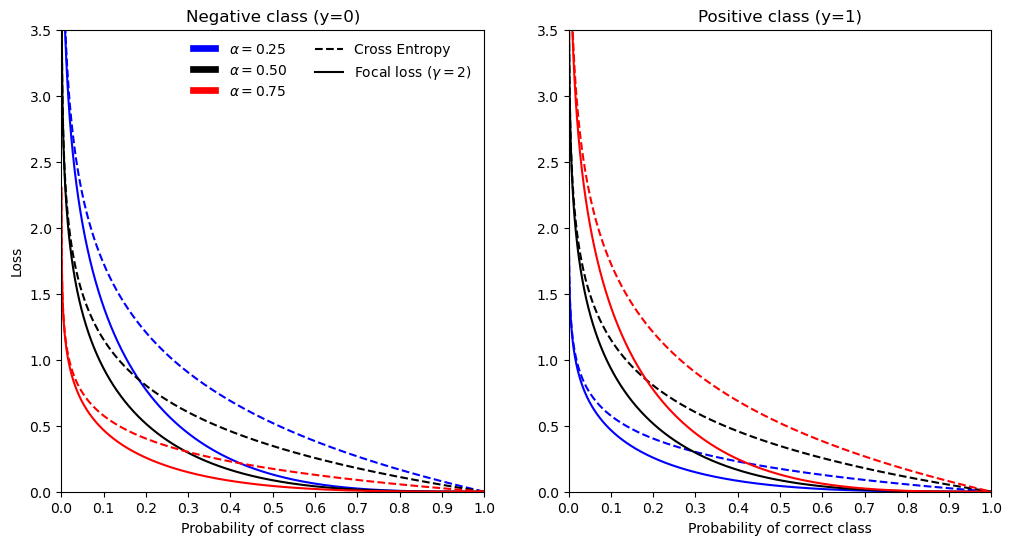

In [531]:
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle

alpha_colors = ['b', 'k', 'r']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x_neg = 1-x 
for i, alpha in enumerate(alpha_vals):
    ax[0].plot(x_neg, focal_losses_neg[i], color=alpha_colors[i])
    ax[0].plot(x_neg, losses_negative[i], linestyle='--', color=alpha_colors[i]) 
ax[0].set_title('Negative class (y=0)')
ax[0].set_xlabel('Probability of correct class')
ax[0].set_ylabel('Loss')
ax[0].set_ylim(0, 3.5)
ax[0].set_xlim(0, 1)

for i, alpha in enumerate(alpha_vals):
    ax[1].plot(x, focal_losses_pos[i], color=alpha_colors[i])
    ax[1].plot(x, losses_positive[i], linestyle='--', color=alpha_colors[i]) 
ax[1].set_title('Negative class (y=0)')
ax[1].set_xlabel('Probability of correct class')
ax[1].set_title('Positive class (y=1)')
ax[1].set_xlabel('Probability of correct class')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_ylim(ax[0].get_ylim())
[ax[i].set_xticks(np.arange(0, 1.1, 0.1)) for i in range(2)]

ce = Line2D([0], [0], color='k', linestyle='--')
focal = Line2D([0], [0], color='k')
alpha_025 = Rectangle((0, 0), 1, 1, fc='b', edgecolor='b', linewidth=0.5)
alpha_050 = Rectangle((0, 0), 1, 1, fc='k', edgecolor='k', linewidth=0.5)
alpha_075 = Rectangle((0, 0), 1, 1, fc='r', edgecolor='r', linewidth=0.5)
handles = [alpha_025, alpha_050, alpha_075, ce, focal]
labels = [r'$\alpha=0.25$', r'$\alpha=0.50$', r'$\alpha=0.75$', 'Cross Entropy', fr'Focal loss ($\gamma={gamma}$)']
for i in range(2):
    ax[i].legend(handles, labels, loc='best', ncols=2, handlelength=2, handleheight=0.25, fontsize=10, frameon=False)
    if i == 1:
        ax[i].get_legend().remove()

plt.show()